In [1]:
from numpy import asarray
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns; sns.set(rc={'figure.figsize':(16,9)})
import matplotlib.pyplot as plt
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

df_payments = pd.read_csv('../input/brazilian-ecommerce/olist_order_payments_dataset.csv')
df_orders = pd.read_csv('../input/brazilian-ecommerce/olist_orders_dataset.csv')
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [2]:
df_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [3]:
df_merged = pd.merge(df_orders, df_payments, on = 'order_id')

In [4]:
df_merged.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value'],
      dtype='object')

In [5]:
df_merged.payment_value.value_counts()

50.00     324
20.00     274
100.00    255
77.57     250
35.00     165
         ... 
90.59       1
334.82      1
361.64      1
43.06       1
495.78      1
Name: payment_value, Length: 29077, dtype: int64

In [6]:
df_merged.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 175
order_delivered_carrier_date     1888
order_delivered_customer_date    3132
order_estimated_delivery_date       0
payment_sequential                  0
payment_type                        0
payment_installments                0
payment_value                       0
dtype: int64

Text(0.5, 1.0, 'Spread of payment types')

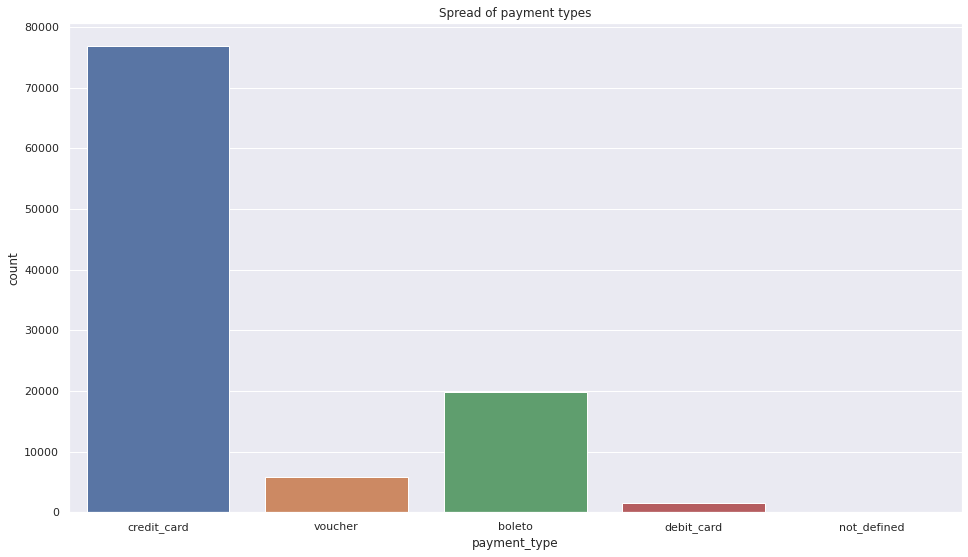

In [7]:
sns.countplot(df_merged.payment_type)
plt.title('Spread of payment types')

Credit card is the most common payment type

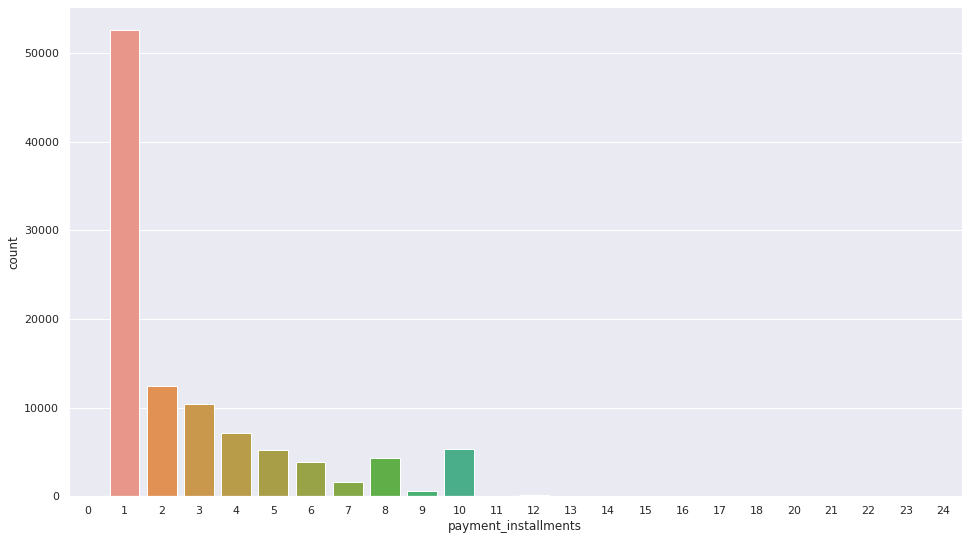

In [8]:
sns.countplot(df_merged['payment_installments'])

Most customers pay only once. 

Text(0.5, 1.0, 'Sales per day')

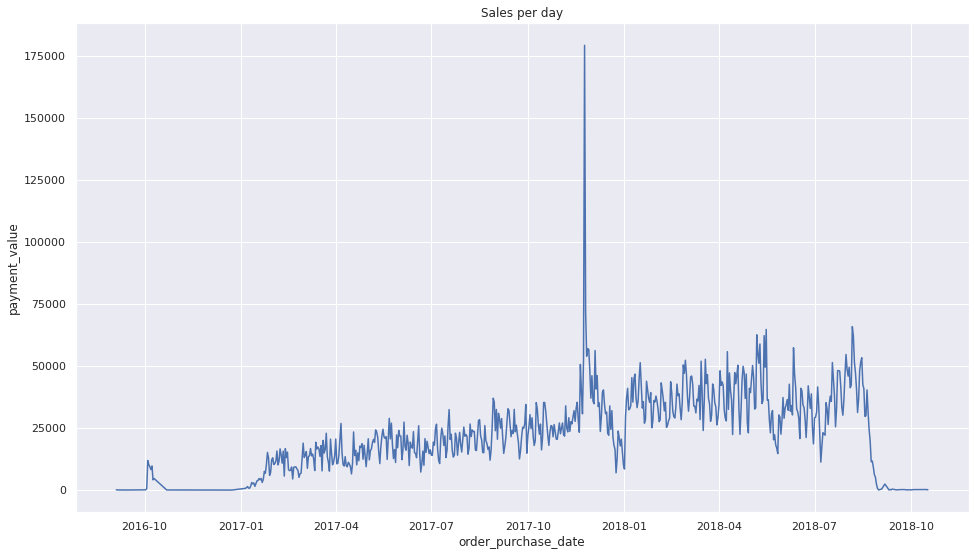

In [9]:
#Set up time series data from this
df_merged.order_purchase_timestamp = pd.to_datetime(df_merged.order_purchase_timestamp)
df_merged['order_purchase_date'] = df_merged.order_purchase_timestamp.dt.date

# creating an aggregation
sales_per_purchase_date = df_merged.groupby('order_purchase_date', as_index=False).payment_value.sum()
ax = sns.lineplot(x="order_purchase_date", y="payment_value", data=sales_per_purchase_date)
ax.set_title('Sales per day')

There's a sharp spike around December 2017 that did not occur in either December 2016 or December 2018. This may be because data was not available for those periods

In [10]:
#convert to numpy array and drop dates column
sales_array = sales_per_purchase_date.drop('order_purchase_date', axis = 1).values

In [11]:
#Function to convert the time series data to a supervised problem
def series_to_supervised(data, n_in=1, n_out = 1, dropnan = True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1,i)) for j in range(n_vars)]
        
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace = True)
    return agg

In [12]:
#apply the function to the numpy array
supervised_sales_array = series_to_supervised(sales_array,7,1)

In [13]:
#Apply minmax scaling to data
scaler = MinMaxScaler(feature_range = (0,1))
scaled_values = scaler.fit_transform(supervised_sales_array)

train = scaled_values[:(len(scaled_values)-30),:]
test = scaled_values[(len(scaled_values)-30):len(scaled_values),:]

train_X, train_y = train[:,:-1], train[:,-1]
test_X, test_y = test[:,:-1], test[:,-1]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(test.shape, train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(30, 8) (596, 1, 7) (596,) (30, 1, 7) (30,)


Epoch 1/100
9/9 - 0s - loss: 0.1068
Epoch 2/100
9/9 - 0s - loss: 0.0368
Epoch 3/100
9/9 - 0s - loss: 0.0485
Epoch 4/100
9/9 - 0s - loss: 0.0446
Epoch 5/100
9/9 - 0s - loss: 0.0387
Epoch 6/100
9/9 - 0s - loss: 0.0352
Epoch 7/100
9/9 - 0s - loss: 0.0350
Epoch 8/100
9/9 - 0s - loss: 0.0342
Epoch 9/100
9/9 - 0s - loss: 0.0327
Epoch 10/100
9/9 - 0s - loss: 0.0320
Epoch 11/100
9/9 - 0s - loss: 0.0314
Epoch 12/100
9/9 - 0s - loss: 0.0310
Epoch 13/100
9/9 - 0s - loss: 0.0306
Epoch 14/100
9/9 - 0s - loss: 0.0304
Epoch 15/100
9/9 - 0s - loss: 0.0301
Epoch 16/100
9/9 - 0s - loss: 0.0299
Epoch 17/100
9/9 - 0s - loss: 0.0297
Epoch 18/100
9/9 - 0s - loss: 0.0295
Epoch 19/100
9/9 - 0s - loss: 0.0293
Epoch 20/100
9/9 - 0s - loss: 0.0292
Epoch 21/100
9/9 - 0s - loss: 0.0290
Epoch 22/100
9/9 - 0s - loss: 0.0290
Epoch 23/100
9/9 - 0s - loss: 0.0289
Epoch 24/100
9/9 - 0s - loss: 0.0288
Epoch 25/100
9/9 - 0s - loss: 0.0287
Epoch 26/100
9/9 - 0s - loss: 0.0287
Epoch 27/100
9/9 - 0s - loss: 0.0286
Epoch 28/1

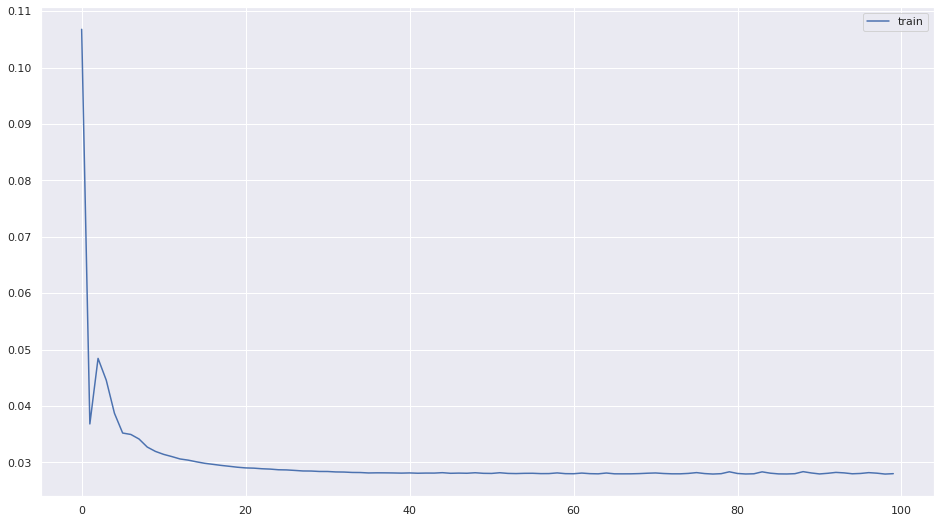

In [14]:
#Create LSTM model and train with supervised data
model = Sequential()
model.add(LSTM(200, input_shape = (train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss = 'mae', optimizer = 'adam')

history = model.fit(train_X, train_y, epochs = 100, batch_size = 72, verbose = 2, shuffle = False)

plt.plot(history.history['loss'], label = 'train')
plt.legend()
plt.show()

In [15]:
#Make predictions with trained model
yhat = model.predict(test_X) #Use the model to make predictions from the testing data

In [16]:
#invert predictions to get output values back and check RMSE
test_X = test_X.reshape(test_X.shape[0], test_X.shape[2])
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
# invert scaling for actual values
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)

# act = [i[7] for i in inv_y] # last element is the predicted average energy
# pred = [i[7] for i in inv_yhat] # last element is the actual average energy
act = inv_y[:,0]
pred = inv_yhat[:,0]
# calculate RMSE
import math
rmse = math.sqrt(mean_squared_error(act, pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 7844.669


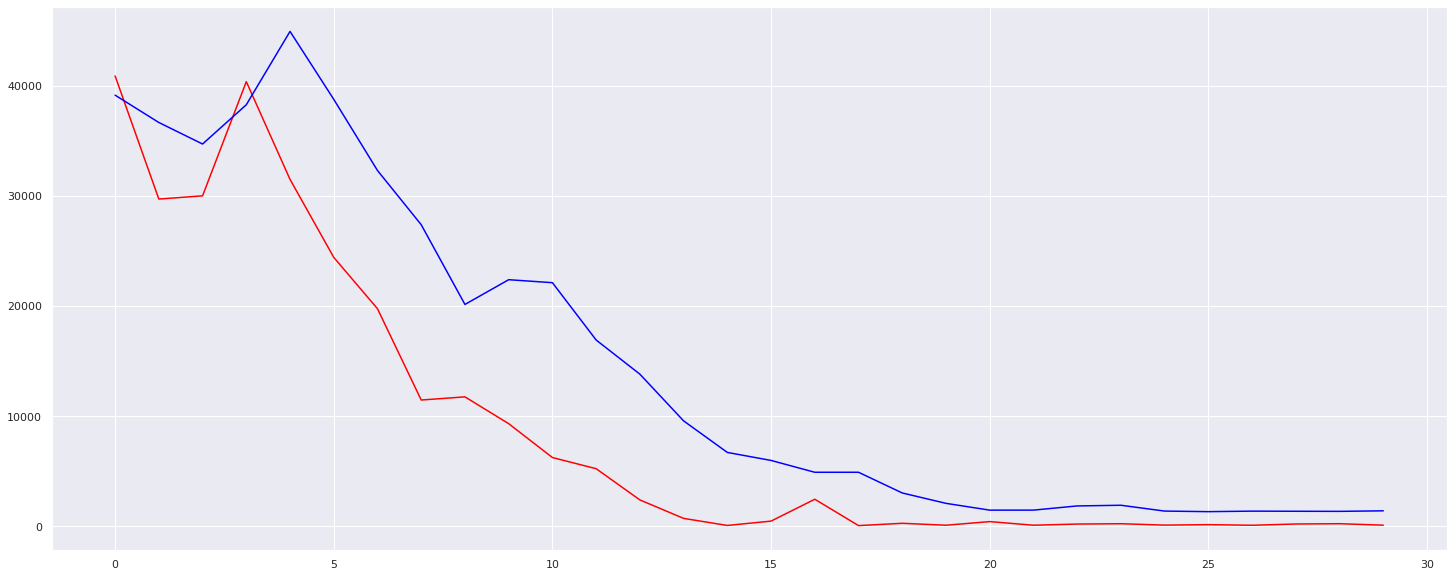

In [17]:
#Graphical illustration
predicted_lstm = pd.DataFrame({'predicted':pred,'actual_sales_values':act})
predicted_lstm['actual_sales_values'].plot(figsize=(25,10),color = 'red')
predicted_lstm['predicted'].plot(color = 'blue')
plt.show()